### Local Variance Estimation

When working with time series (observations of a natural sequential ordering) one often wishes to estimate the variance of the time series locally. This notebook will go over a collection of methods that can be utilized to create an estimator for the local variance (or volatility) function

In [1]:

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")


PATH = "../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [23]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=10000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


In [24]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


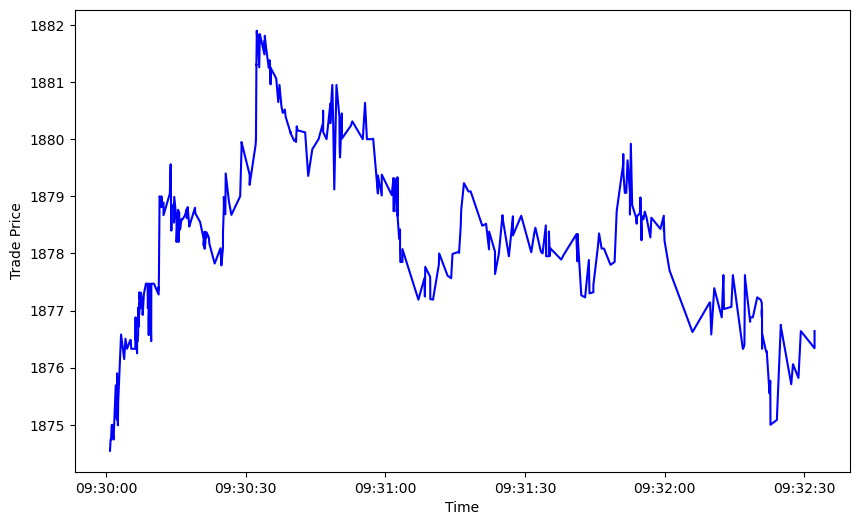

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, regular_trades["Trade_Price"], color="blue", label="Trade Price")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Price")

plt.show()


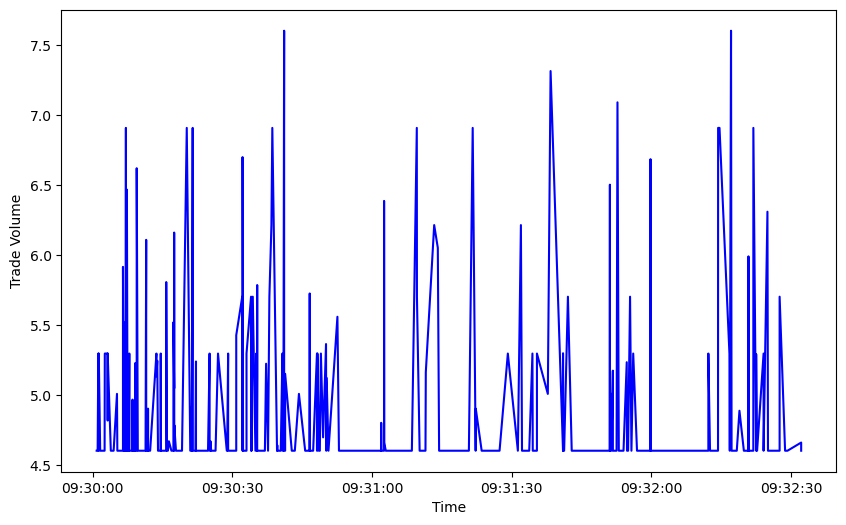

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, np.log(regular_trades["Trade_Volume"]), color="blue", label="Trade Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Volume")

plt.show()


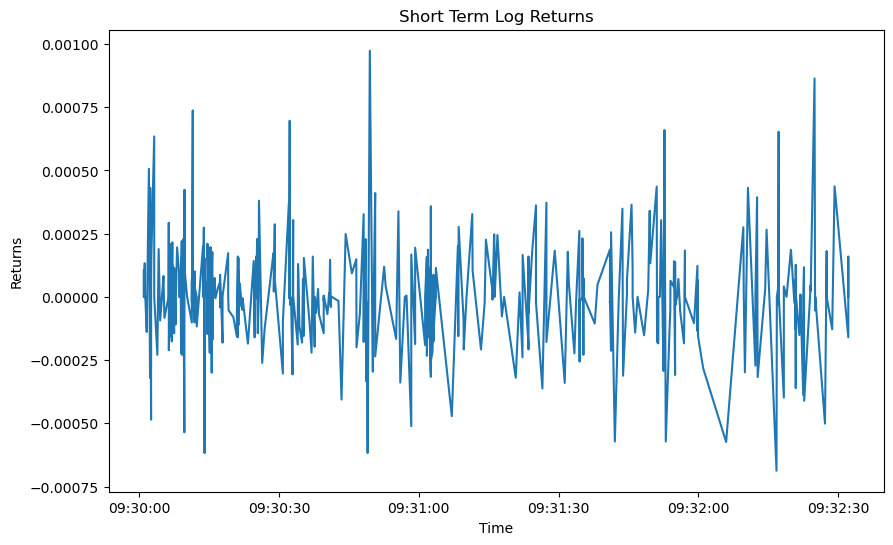

In [29]:
returns= np.log(regular_trades["Trade_Price"][1:].values/regular_trades["Trade_Price"][:-1].values)

returns=pd.Series(returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns)
ax.set_title("Short Term Log Returns")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


### Local Variance Estimators

Assuming that $E[r_t] = 0$ for all $t$, the local variance of a time series $r_t$ is defined as

$$\sigma^2_t = \frac{1}{T}\sum_{i=1}^T r_i^2$$

where $T$ is the window size. This is the most basic estimator of the local variance, and is often referred to as the "naive" estimator. It is also known as the "sample variance" estimator. The sample variance estimator is unbiased, but has high variance. This is because the variance of the sample mean is proportional to $1/T$, and the variance of the sample variance is proportional to $1/T^2$. This means that the variance of the sample variance is proportional to $1/T$, which is why the sample variance estimator has high variance.

In [30]:
def sample_variance(returns, T):

    def compute_sample_variance(x):
        return (x**2).sum() / (T )
    return returns.rolling(T).apply(lambda x: compute_sample_variance(x))

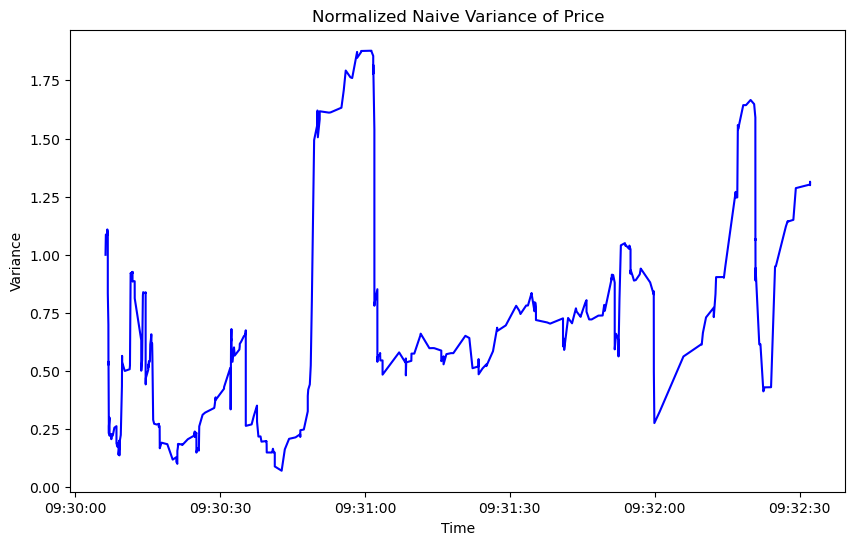

In [31]:
naive_variance = sample_variance(returns, 25).dropna()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(naive_variance.index, naive_variance.values/naive_variance.values[0], color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Price")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()



### Trade Volume

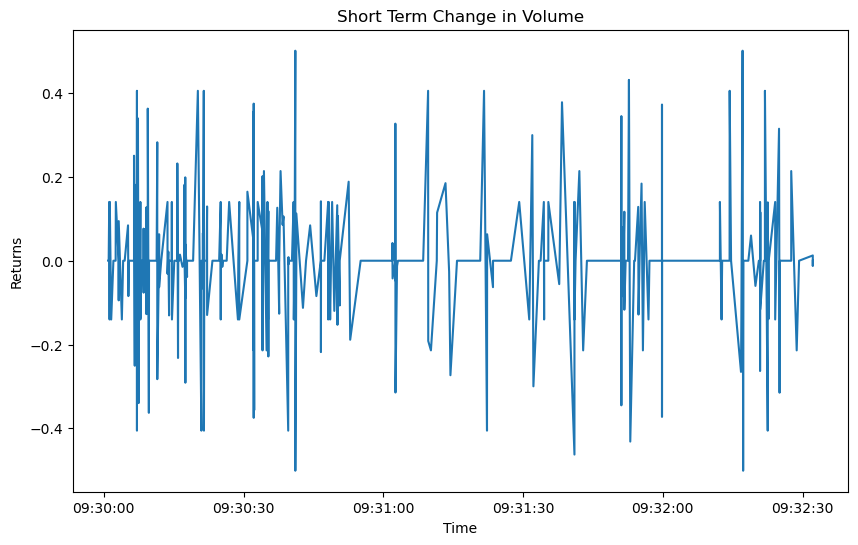

In [32]:
volume_returns = np.log(np.log(regular_trades["Trade_Volume"][1:].values)/np.log(regular_trades["Trade_Volume"][:-1].values))

volume_returns = pd.Series(volume_returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(volume_returns)
ax.set_title("Short Term Change in Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


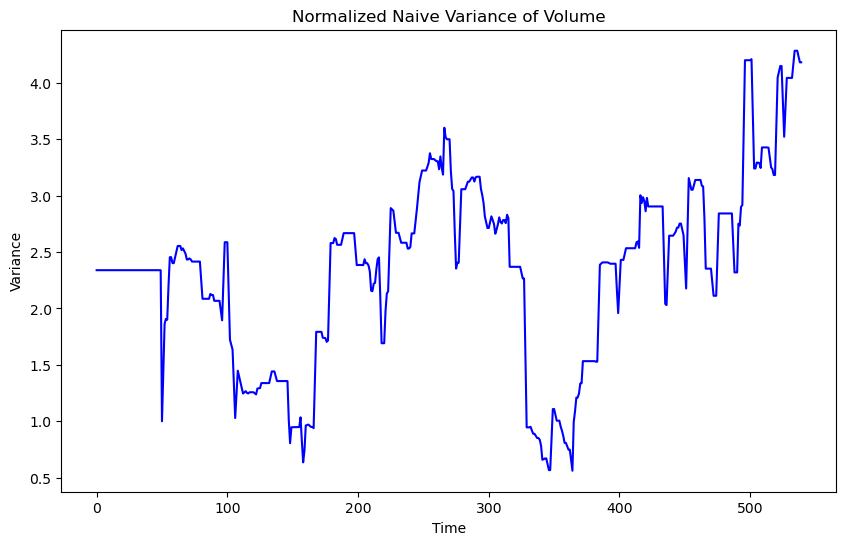

In [33]:
naive_volume_variance = sample_variance(volume_returns, 50).dropna()

volume_local_variance=naive_volume_variance/naive_volume_variance.values[0]

volume_local_variance=np.pad(volume_local_variance, (50,0), 'mean')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot( volume_local_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()



### Projecting the local variance estimator to much lower dimensional subspace (piecewise constant)

One way we can adaptively filter is by estimating the local variance of the exogenous covariate as a piecewise constant series. Using the TF to select optimal knots, one can then apply a DP search algorithm to select model

In [34]:
from model_selection.partition import partition_solver

from model_selection.model_selection import ratio_model_selection


In [46]:
candidate_knots=np.arange(0,len(volume_local_variance),100)

partition_solver(volume_local_variance,candidate_knots,10,0)

{1: [1],
 2: [1, 500],
 3: [1, 100, 500],
 4: [1, 100, 400, 500],
 5: [1, 100, 200, 300, 500],
 6: [1, 100, 200, 300, 400, 500],
 0: []}

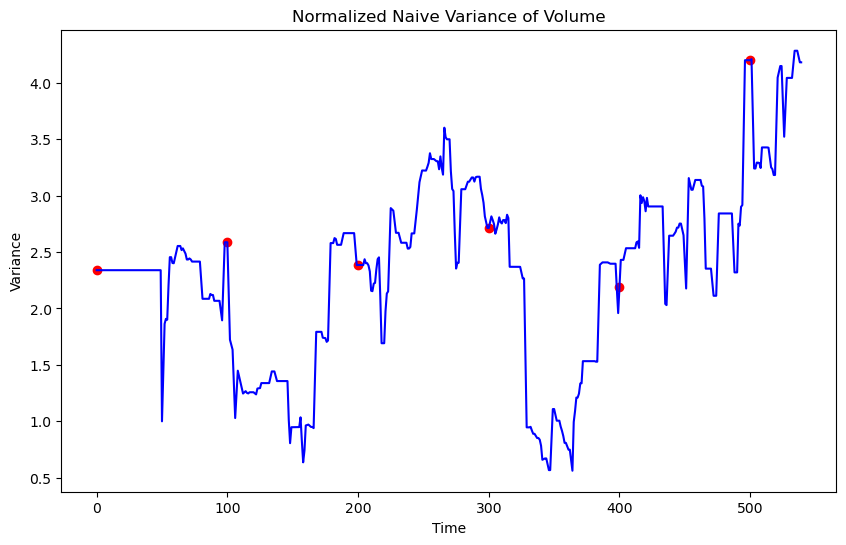

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot( volume_local_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Variance")

ax.scatter(candidate_knots, volume_local_variance[candidate_knots], color="red", label="Candidate Knots")

### Regression Trees

Decision Trees / Regression Trees are great models for generating piecewise constant estimates. They are also very easy to implement. The downside is that they are not very flexible, and can only generate piecewise constant estimates. This is a problem because the local variance is not piecewise constant. However, we can use the regression tree to generate a coarse estimate of the local variance, and then use this as an adaptive filter when trend filtering the time series.

In [48]:
from sklearn import tree


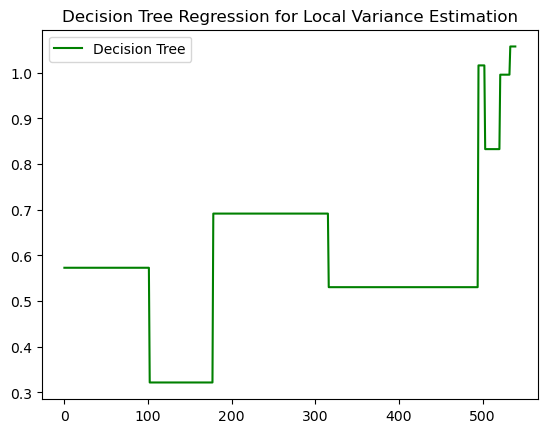

In [58]:
model=tree.DecisionTreeRegressor(max_depth=3)

model.fit(np.arange(len(volume_local_variance)).reshape(-1,1), volume_local_variance)

predictions=model.predict(np.arange(len(volume_local_variance)).reshape(-1,1))/4

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len(volume_local_variance)), predictions, color="green", label="Decision Tree")

plt.legend()

### Effect of Volume Variance on Trend Filtering

In [59]:
from matrix_algorithms.difference_matrix import Difference_Matrix
from trend_filtering.cv_tf import cross_validation
from trend_filtering.adaptive_tf import adaptive_tf

In [60]:
trade_price=regular_trades["Trade_Price"].values

D=Difference_Matrix(len(trade_price),k=1)
best_lambda=cross_validation(trade_price.reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=True)



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.5893817496130622
Performing cross validation for lambda = 3.068615734306425
Performing cross validation for lambda = 5.92456942904082
Performing cross validation for lambda = 11.438552741260253
Performing cross validation for lambda = 22.084387799262437
Performing cross validation for lambda = 42.63827736781294
Performing cross validation for lambda = 82.32162527753059
Performing cross validation for lambda = 158.9381749613062
Performing cross validation for lambda = 306.86157343064247
Performing cross validation for lambda = 592.456942904082
Performing cross validation for lambda = 1143.8552741260241
Performing cross validation for lambda = 2208.438779926244
Performing cross validation for lambda = 4263.827736781294
Performing cross validation for lambda = 8232.16252775305
Performing cross validation for lambda = 15893.817496130621
No solution found for lambda = 15893.817496130621
Status: 

In [61]:
print(f"Best lambda: {best_lambda}")

results=adaptive_tf(trade_price.reshape(-1,1), D, best_lambda,select_knots=True)

Best lambda: 2.7159629990800735
k: 0 mse: 2.1053618609231473
k: 1 mse: 0.7171235263614724
k: 2 mse: 0.6284663425887813
k: 3 mse: 0.5876319712965467
k: 4 mse: 0.5547010276678875
k: 5 mse: 0.5410535341563646
k: 6 mse: 0.5205929408666965
k: 7 mse: 0.5064881159303545
k: 8 mse: 0.5206343155859726
k: 9 mse: 0.6425850434010101


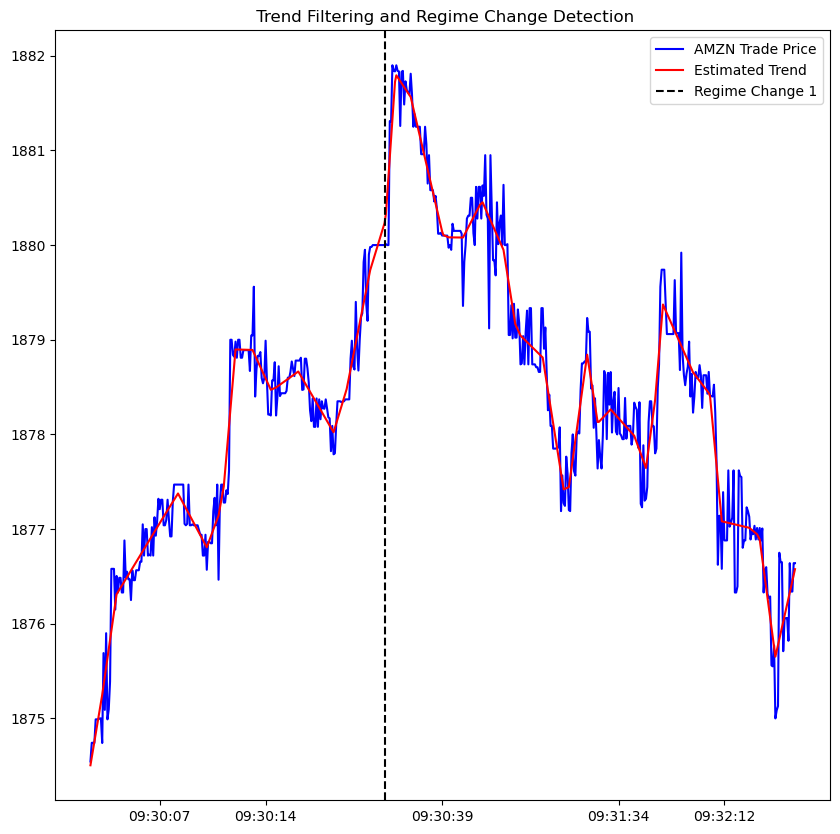

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(results["sol"].x, label="Estimated Trend ",color='red')

for i in range(len(results["sol"].knots)):
    ax.axvline(results["sol"].knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Adaptive Trend Filtering

In [67]:
trade_price=regular_trades["Trade_Price"].values

D=Difference_Matrix(len(trade_price),k=1,prior=1/predictions)
best_lambda=cross_validation(trade_price.reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=True)



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.082107251403584
Performing cross validation for lambda = 2.0892220126929955
Performing cross validation for lambda = 4.033656195039258
Performing cross validation for lambda = 7.787770854858154
Performing cross validation for lambda = 15.0358315025378
Performing cross validation for lambda = 29.02964573382095
Performing cross validation for lambda = 56.04747108857348
Performing cross validation for lambda = 108.2107251403584
Performing cross validation for lambda = 208.92220126929953
Performing cross validation for lambda = 403.3656195039258
Performing cross validation for lambda = 778.7770854858145
Performing cross validation for lambda = 1503.58315025378
Performing cross validation for lambda = 2902.9645733820953
Performing cross validation for lambda = 5604.747108857342
Performing cross validation for lambda = 10821.07251403584
No solution found for lambda = 10821.07251403584
Status: neg

In [68]:
print(f"Best lambda: {best_lambda}")

results=adaptive_tf(trade_price.reshape(-1,1), D, best_lambda,select_knots=True)

Best lambda: 97.28219768732961
k: 0 mse: 1.821140543303656
k: 1 mse: 0.2824108181465975
k: 2 mse: 0.24293827813181362
k: 3 mse: 0.09612613507812034
k: 4 mse: 0.05665359506333649
k: 5 mse: 0.012833633553433008
k: 6 mse: 0.004888206296064883
k: 7 mse: 5.63044485079252e-05


In [69]:
results["sol"].all_models


{0: 0.15507359889659458,
 1: 0.8602300709518359,
 2: 0.3956813056276136,
 3: 0.5893672414613873,
 4: 0.2265281406958466,
 5: 0.38089028143999665,
 6: 0.011518427230301545}

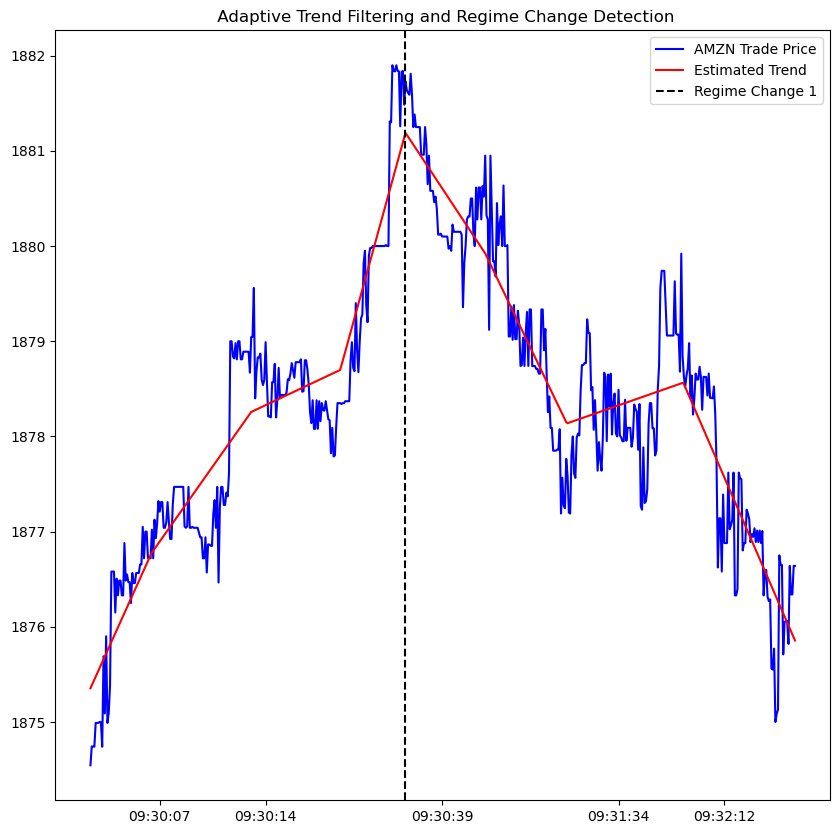

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(results["sol"].x, label="Estimated Trend ",color='red')

for i in range(len(results["sol"].knots)):
    ax.axvline(results["sol"].knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))